## Import Libraries

In [205]:
import numpy as np
import pandas as pd
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import LabelEncoder, TargetEncoder


In [237]:
train_url = 'data/train.csv'
test_url = 'data/test.csv'

train = pd.read_csv(train_url)
test = pd.read_csv(test_url)

train.head()

,id,Country,Year,Month,FoodPriceIndex
0,3501,Mexico,1971,11,0.0
1,60601,South Africa,2002,7,43.9
2,64399,Japan,2004,8,89.8
3,24227,France,1983,1,48.9
4,63779,Japan,2004,4,90.2


In [207]:
test.head()

,id,Country,Year,Month
0,99116,Italy,2023,4
1,97687,Denmark,2022,7
2,92061,United States,2019,6
3,95122,Netherlands,2021,2
4,92296,Italy,2019,8


### Checking Train Data

In [208]:
print("Train Data missing values:")
print(train.isna().sum())

print("Train Data duplicated: ", train.duplicated().sum())
print('-'*50)

print("Train Data Length: ", len(train))

Train Data missing values:
id                  0
Country             0
Year                0
Month               0
FoodPriceIndex    348
dtype: int64
Train Data duplicated:  0
--------------------------------------------------
Train Data Length:  11616


In [209]:
proportion_missing = train.isna().sum() / len(train)
print(proportion_missing)

id                0.000000
Country           0.000000
Year              0.000000
Month             0.000000
FoodPriceIndex    0.029959
dtype: float64


missing value < 0.05 berarti kita remove aja yang missing value (`Complete Case Analysis`)

In [210]:
# Menghapus baris dengan missing value
train.dropna(subset=['FoodPriceIndex'], inplace=True)

print(train.isna().sum())

id                0
Country           0
Year              0
Month             0
FoodPriceIndex    0
dtype: int64


In [211]:
len(train)

11268

### Checking Test Data

In [212]:
print("Test Data missing values:")
print(test.isna().sum())

print("Test Data duplicated: ", test.duplicated().sum())

print('-'*50)

print("Train Data Length: ", len(train))

Test Data missing values:
id         0
Country    0
Year       0
Month      0
dtype: int64
Test Data duplicated:  0
--------------------------------------------------
Train Data Length:  11268


## EDA

In [213]:
num_cols = train.select_dtypes(include=[np.number]).columns
cat_cols = train.select_dtypes(exclude=[np.number]).columns

print('Numerical Columns: ', num_cols)
print('Categorical Columns: ', cat_cols)

Numerical Columns:  Index(['id', 'Year', 'Month', 'FoodPriceIndex'], dtype='object')
Categorical Columns:  Index(['Country'], dtype='object')


In [214]:
train['Country'].value_counts()

Country
Finland           519
Germany           516
Japan             516
Mexico            515
Greece            515
Sweden            515
Turkey            514
Portugal          513
France            513
Spain             513
Italy             513
Israel            513
United Kingdom    512
Austria           511
Canada            511
Taiwan, China     511
Denmark           509
South Africa      509
Netherlands       509
United States     509
Switzerland       508
Luxembourg        504
Name: count, dtype: int64

In [215]:
test['Country'].value_counts()

Country
Italy             120
Denmark           120
Luxembourg        120
South Africa      120
Austria           120
Sweden            120
Germany           120
Spain             120
Mexico            120
France            120
Greece            120
Switzerland       120
Israel            120
United Kingdom    120
Turkey            120
Taiwan, China     120
Finland           120
Portugal          120
Canada            120
Netherlands       120
United States     120
Japan             120
Name: count, dtype: int64

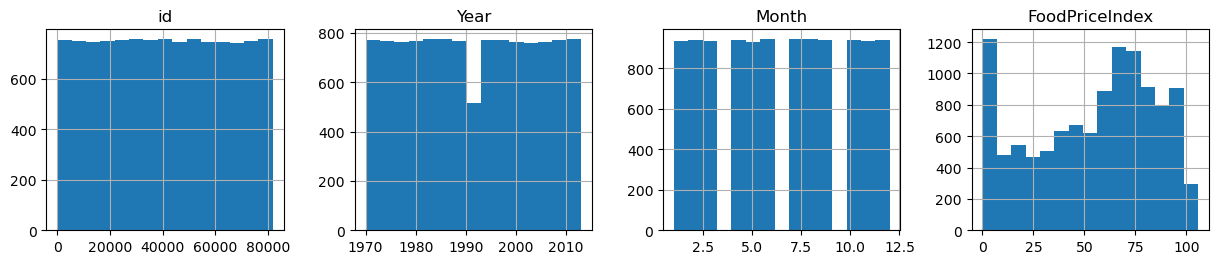

In [216]:
train[num_cols].hist(bins=15, figsize=(15, 6), layout=(2, 4));

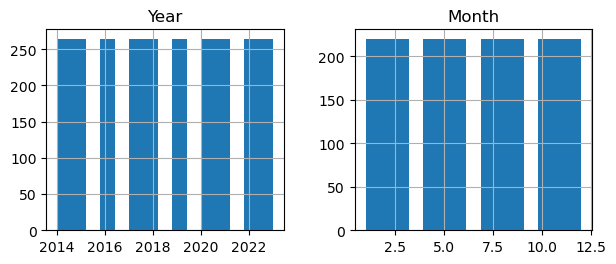

In [217]:
test[['Year', 'Month']].hist(bins=15, figsize=(15, 6), layout=(2, 4));

Might need to scale our data

### Heatmap Correlation

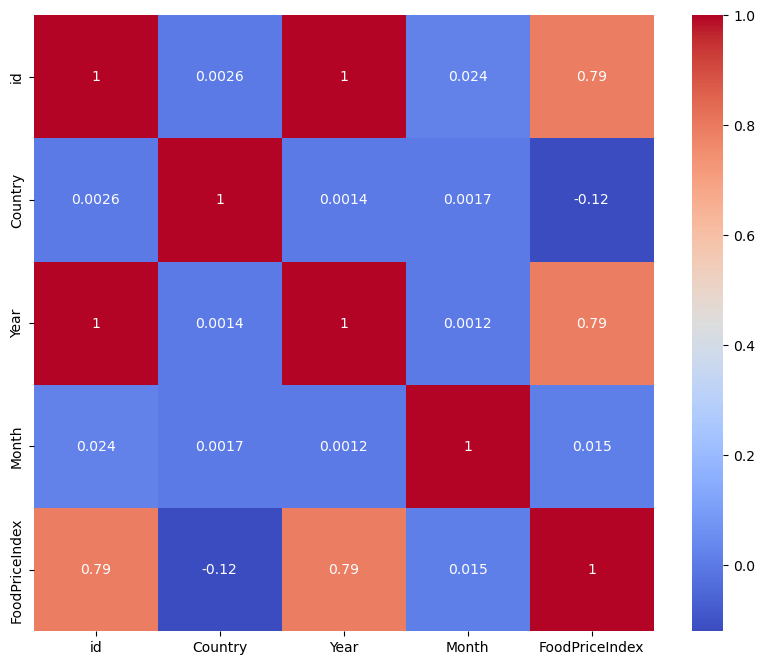

In [218]:
le = LabelEncoder()

train2 = train.copy()

train2['Country'] = le.fit_transform(train2['Country'])

corr_mat = train2.corr()
plt.figure(figsize=(10, 8))
sns.heatmap(corr_mat, annot=True, cmap='coolwarm')
plt.show()

Yang paling berpengaruh dengan `FoodIndex` hanya Year dengan hasil korelasi pearson 0.79.

Method yang bisa diuji (Time Series Forecasting):
- Arima
- Prophet
- RandomForestRegressor

### Boxplot

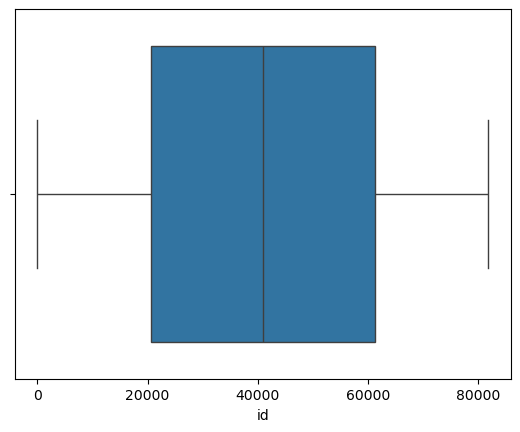

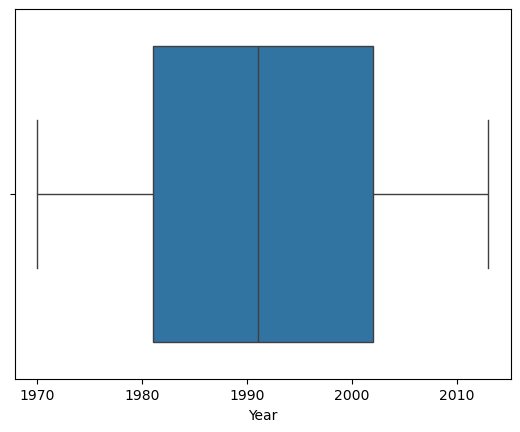

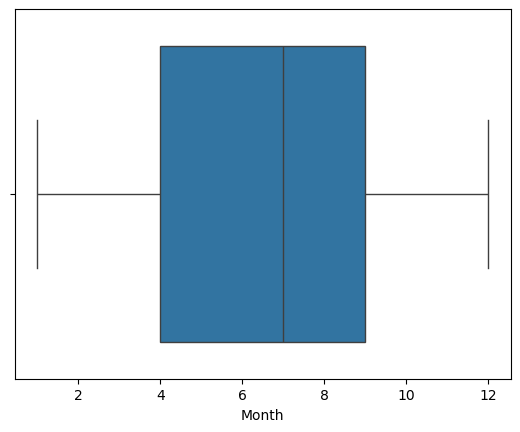

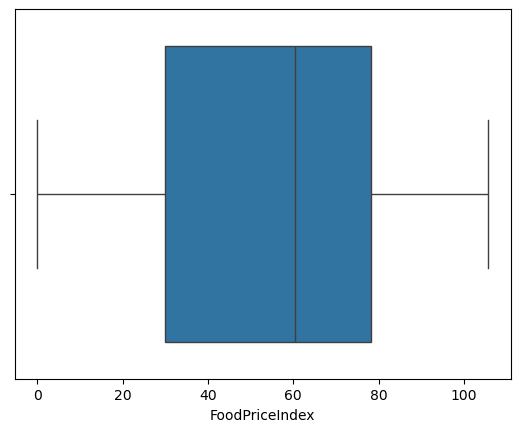

In [219]:
for col in num_cols:
    sns.boxplot(x=train[col])
    plt.show()

No need to handle outlier, karena data kita juga terdistribusi uniform.

## Modelling

In [220]:
X = train.drop(columns=['FoodPriceIndex', 'id'])
y = train['FoodPriceIndex']

In [221]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

X_train.shape, X_val.shape, y_train.shape, y_val.shape

((9014, 3), (2254, 3), (9014,), (2254,))

In [222]:
# set Country to TargetEncoder using category_encoders library
import category_encoders as ce


te = ce.TargetEncoder(cols=['Country'])
X_train = te.fit_transform(X_train, y_train)
X_val = te.transform(X_val)

In [223]:
X_train

,Country,Year,Month
10426,52.708049,1999,5
6551,59.943839,1992,11
8899,71.744059,1990,2
11548,25.432524,2010,6
9181,71.744059,2001,6
...,...,...,...
5923,38.852580,1975,6
5366,50.129975,2004,2
5569,68.940091,2012,4
884,15.753071,1995,10


Evaluasi metrik

In [224]:
# Calculate sMAPE
def smape(A, F):
    denominator = np.abs(A) + np.abs(F)
    numerator = 2 * np.abs(F - A)
    print(f"Denominator: {denominator}")
    print(f"Numerator: {numerator}")
    return 100/len(A) * np.sum(numerator / denominator)


Denominator: [108.96008879 104.14763731 116.92467158 ... 190.52595637 196.42595637
 195.72595637]
Numerator: [165.92017759 177.09527462 151.44934315 ...   4.25191273   7.54808727
   6.14808727]
sMAPE: 69.02%


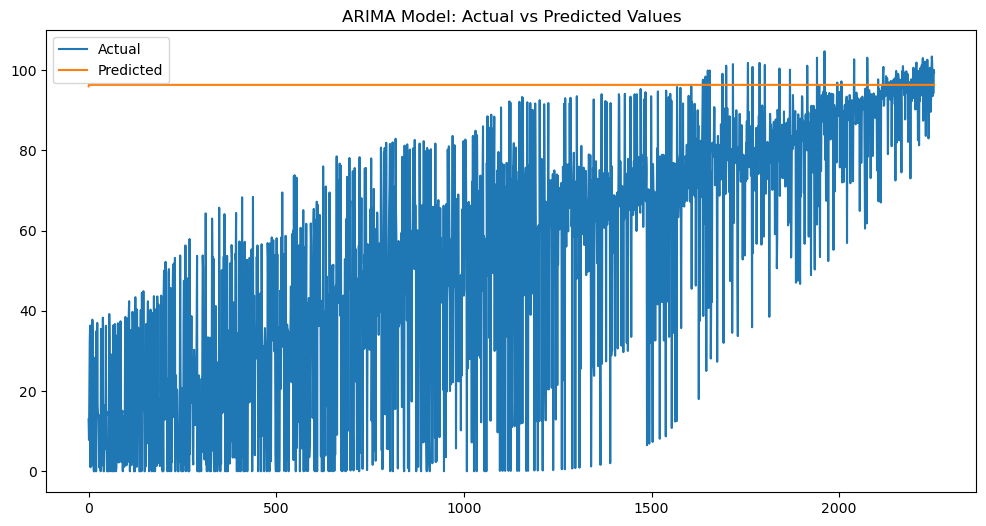

In [225]:
import numpy as np
from statsmodels.tsa.arima.model import ARIMA

# Sort data by Year and Month to ensure time series order
X_train_sorted = pd.concat([y_train, X_train], axis=1).sort_values(['Year', 'Month'])
X_val_sorted = pd.concat([y_val, X_val], axis=1).sort_values(['Year', 'Month'])

# Fit ARIMA model
model = ARIMA(X_train_sorted['FoodPriceIndex'], order=(1,1,1))
results = model.fit()

# Make predictions
predictions = results.forecast(steps=len(y_val))

smape_arima = smape(X_val_sorted['FoodPriceIndex'].values, predictions.values)
print(f'sMAPE: {smape_arima:.2f}%')

# Plot actual vs predicted values
plt.figure(figsize=(12,6))
plt.plot(X_val_sorted['FoodPriceIndex'].values, label='Actual')
plt.plot(predictions.values, label='Predicted')
plt.title('ARIMA Model: Actual vs Predicted Values')
plt.legend()
plt.show()

Denominator: [109.28801236 104.95996356 117.83252149 ... 213.0180906  218.10017322
 216.64523026]
Numerator: [166.57602472 178.71992712 153.26504299 ...  49.23618121  35.80034643
  35.69046052]
sMAPE: 78.26%


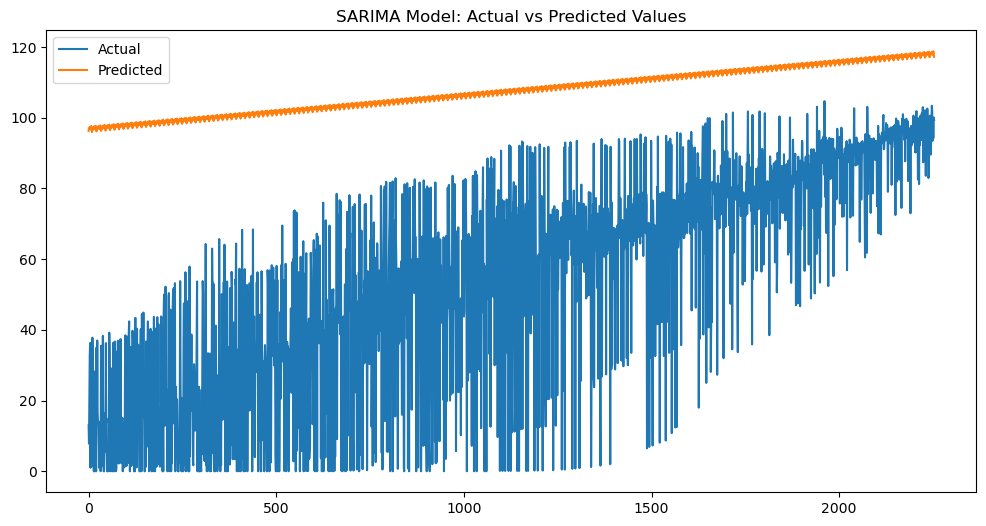

In [226]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

# Sort data by Year and Month to ensure time series order
X_train_sorted = pd.concat([y_train, X_train], axis=1).sort_values(['Year', 'Month'])
X_val_sorted = pd.concat([y_val, X_val], axis=1).sort_values(['Year', 'Month'])

# Fit SARIMA model
# Using order=(1,1,1) for ARIMA part and seasonal_order=(1,1,1,12) for seasonal part
model = SARIMAX(X_train_sorted['FoodPriceIndex'], 
                order=(1,1,1), 
                seasonal_order=(1,1,1,12))
results = model.fit()

# Make predictions
predictions = results.forecast(steps=len(y_val))

smape_sarima = smape(X_val_sorted['FoodPriceIndex'].values, predictions.values)
print(f'sMAPE: {smape_sarima:.2f}%')

# Plot actual vs predicted values
plt.figure(figsize=(12,6))
plt.plot(X_val_sorted['FoodPriceIndex'].values, label='Actual')
plt.plot(predictions.values, label='Predicted')
plt.title('SARIMA Model: Actual vs Predicted Values')
plt.legend()
plt.show()

09:13:08 - cmdstanpy - INFO - Chain [1] start processing
09:13:09 - cmdstanpy - INFO - Chain [1] done processing


Denominator: [ 24.69035658  19.49035658  32.29035658 ... 190.73452606 196.63452606
 195.93452606]
Numerator: [ 2.61928684  7.78071316 17.81928684 ...  4.66905212  7.13094788
  5.73094788]
sMAPE: 41.92%


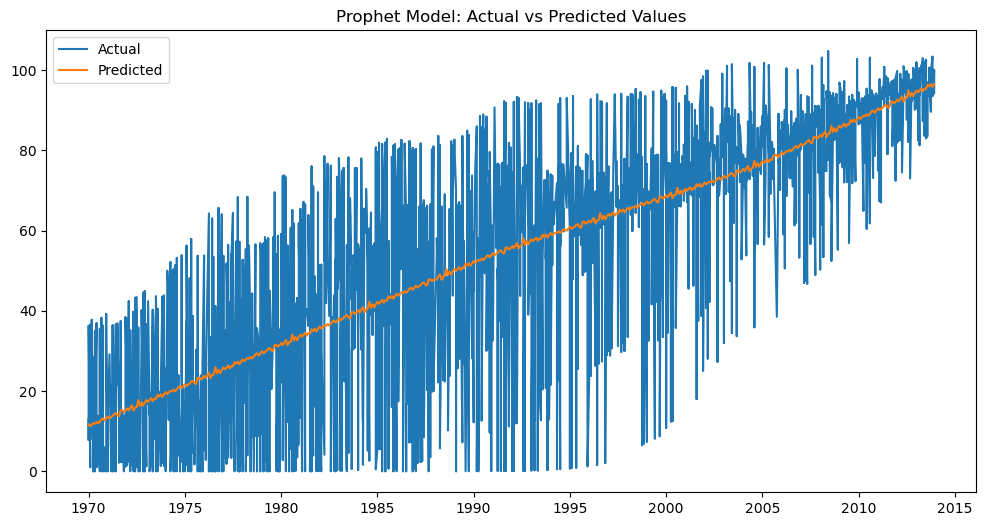

In [227]:
from prophet import Prophet

# Prepare data for Prophet (requires 'ds' and 'y' columns)
# Sort by date and reset index
prophet_train = pd.DataFrame({
    'ds': pd.to_datetime(X_train_sorted['Year'].astype(str) + '-' + X_train_sorted['Month'].astype(str) + '-01'),
    'y': X_train_sorted['FoodPriceIndex']
})

prophet_val = pd.DataFrame({
    'ds': pd.to_datetime(X_val_sorted['Year'].astype(str) + '-' + X_val_sorted['Month'].astype(str) + '-01'),
    'y': X_val_sorted['FoodPriceIndex']
})

# Fit Prophet model
model = Prophet(yearly_seasonality=True, weekly_seasonality=False, daily_seasonality=False)
model.fit(prophet_train)

# Make predictions
forecast = model.predict(prophet_val)

# Calculate sMAPE
smape_prophet = smape(prophet_val['y'].values, forecast['yhat'].values)
print(f'sMAPE: {smape_prophet:.2f}%')

# Plot actual vs predicted values
plt.figure(figsize=(12,6))
plt.plot(prophet_val['ds'], prophet_val['y'], label='Actual')
plt.plot(prophet_val['ds'], forecast['yhat'], label='Predicted')
plt.title('Prophet Model: Actual vs Predicted Values')
plt.legend()
plt.show()

Epoch 1/50
282/282 [==============================] - 2s 2ms/step - loss: 0.1257 - val_loss: 0.0865
Epoch 2/50
282/282 [==============================] - 1s 2ms/step - loss: 0.0837 - val_loss: 0.0833
Epoch 3/50
282/282 [==============================] - 0s 1ms/step - loss: 0.0819 - val_loss: 0.0827
Epoch 4/50
282/282 [==============================] - 0s 2ms/step - loss: 0.0817 - val_loss: 0.0828
Epoch 5/50
282/282 [==============================] - 1s 2ms/step - loss: 0.0815 - val_loss: 0.0826
Epoch 6/50
282/282 [==============================] - 0s 2ms/step - loss: 0.0815 - val_loss: 0.0827
Epoch 7/50
282/282 [==============================] - 0s 2ms/step - loss: 0.0816 - val_loss: 0.0825
Epoch 8/50
282/282 [==============================] - 0s 1ms/step - loss: 0.0815 - val_loss: 0.0826
Epoch 9/50
282/282 [==============================] - 1s 2ms/step - loss: 0.0818 - val_loss: 0.0824
Epoch 10/50
282/282 [==============================] - 1s 2ms/step - loss: 0.0815 - val_loss: 0.0825

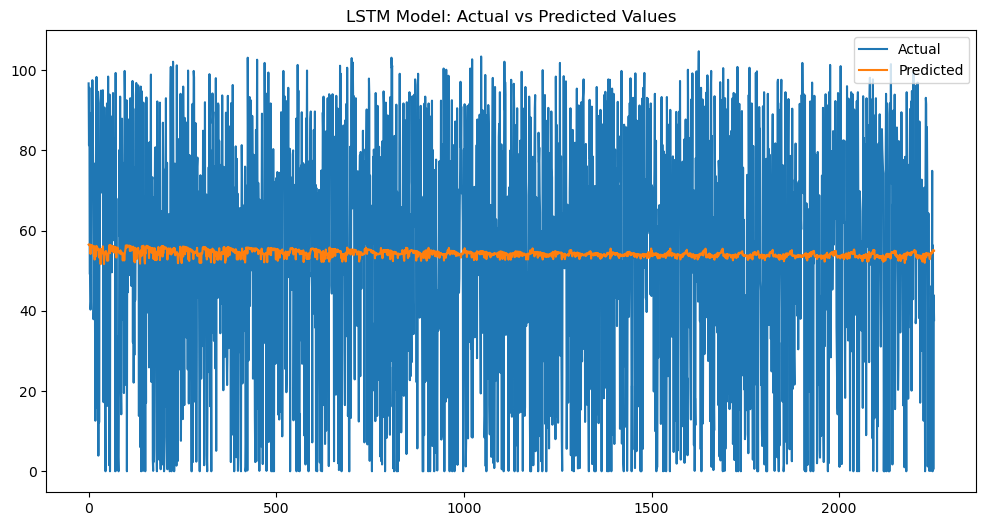

In [228]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from sklearn.preprocessing import MinMaxScaler

# Scale the data
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train_sorted[['Country', 'Year', 'Month']])
X_val_scaled = scaler.transform(X_val_sorted[['Country', 'Year', 'Month']])

y_scaler = MinMaxScaler()
y_train_scaled = y_scaler.fit_transform(y_train.values.reshape(-1,1))
y_val_scaled = y_scaler.transform(y_val.values.reshape(-1,1))

# Reshape input data for LSTM [samples, time steps, features]
X_train_reshaped = X_train_scaled.reshape((X_train_scaled.shape[0], 1, X_train_scaled.shape[1]))
X_val_reshaped = X_val_scaled.reshape((X_val_scaled.shape[0], 1, X_val_scaled.shape[1]))

# Build LSTM model
model = Sequential([
    LSTM(50, activation='relu', input_shape=(1, 3)),
    Dense(1)
])

model.compile(optimizer='adam', loss='mse')

# Train the model
history = model.fit(X_train_reshaped, y_train_scaled, 
                   epochs=50,
                   batch_size=32,
                   validation_data=(X_val_reshaped, y_val_scaled),
                   verbose=1)

# Make predictions
predictions_scaled = model.predict(X_val_reshaped)
predictions = y_scaler.inverse_transform(predictions_scaled)

# Calculate sMAPE
smape_lstm = smape(y_val.values, predictions.flatten())
print(f'sMAPE: {smape_lstm:.2f}%')

# Plot results
plt.figure(figsize=(12,6))
plt.plot(y_val.values, label='Actual')
plt.plot(predictions, label='Predicted')
plt.title('LSTM Model: Actual vs Predicted Values')
plt.legend()
plt.show()

Denominator: [ 26.319   15.849   41.383  ... 187.118  199.963  198.4146]
Numerator: [0.638  0.498  0.366  ... 2.564  0.474  0.7708]
sMAPE: nan%


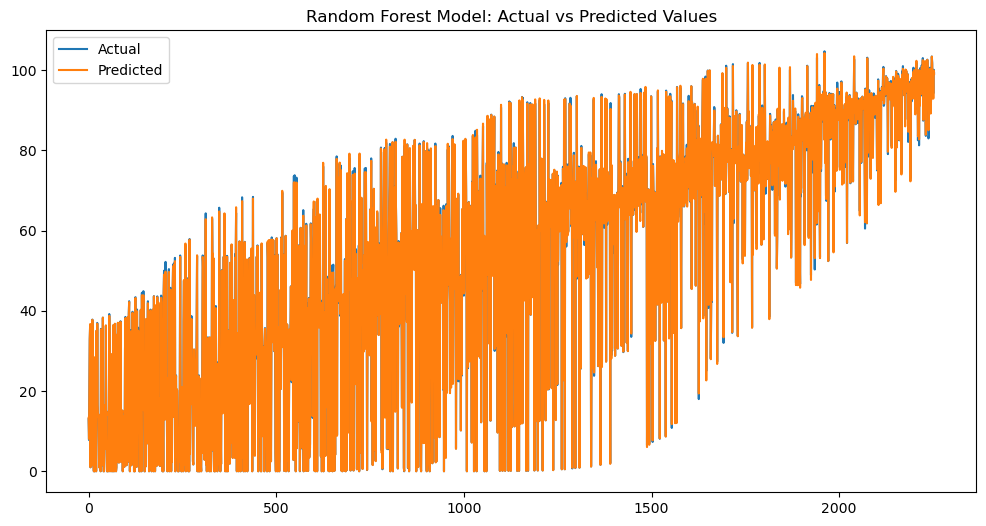


Feature Importance:
   feature  importance
1     Year    0.660372
0  Country    0.338778
2    Month    0.000850


In [229]:
from sklearn.ensemble import RandomForestRegressor

# Initialize and train the model
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train_sorted[['Country', 'Year', 'Month']], X_train_sorted['FoodPriceIndex'])

# Make predictions
rf_predictions = rf_model.predict(X_val_sorted[['Country', 'Year', 'Month']])

# Calculate sMAPE
smape_rf = smape(X_val_sorted['FoodPriceIndex'].values, rf_predictions)
print(f'sMAPE: {smape_rf:.2f}%')

# Plot actual vs predicted values
plt.figure(figsize=(12,6))
plt.plot(X_val_sorted['FoodPriceIndex'].values, label='Actual')
plt.plot(rf_predictions, label='Predicted')
plt.title('Random Forest Model: Actual vs Predicted Values')
plt.legend()
plt.show()

# Feature importance
feature_importance = pd.DataFrame({
    'feature': ['Country', 'Year', 'Month'],
    'importance': rf_model.feature_importances_
})
print("\nFeature Importance:")
print(feature_importance.sort_values('importance', ascending=False))

In [230]:
rf_predictions

array([13.319 ,  8.049 , 20.783 , ..., 92.918 , 99.863 , 99.0146])

In [232]:
# Check for zero or NaN values in actual values
zero_mask = X_val_sorted['FoodPriceIndex'] == 0
print(f"Zero values in actuals: {X_val_sorted['FoodPriceIndex'][zero_mask].shape[0]}")

# Check for NaN values in actual and predicted values
print(f"NaN values in actuals: {X_val_sorted['FoodPriceIndex'].isna().sum()}")
print(f"NaN values in predictions: {np.isnan(rf_predictions).sum()}")

# Check if actual and predicted values have the same length
print(f"Length of actuals: {len(X_val_sorted['FoodPriceIndex'])}")
print(f"Length of predictions: {len(rf_predictions)}")

# Inspect predictions to ensure they're not constant or unrealistic
print(f"Sample of predictions: {rf_predictions[:10]}")


Zero values in actuals: 103
NaN values in actuals: 0
NaN values in predictions: 0
Length of actuals: 2254
Length of predictions: 2254
Sample of predictions: [13.319   8.049  20.783  33.034  36.6845  1.     16.362   1.375  36.6845
  8.049 ]


In [233]:
# Filter out zero actual values
non_zero_mask = X_val_sorted['FoodPriceIndex'] != 0

# Apply the mask to both actual and predicted values
smape_rf = smape(X_val_sorted['FoodPriceIndex'][non_zero_mask].values, 
                 rf_predictions[non_zero_mask])

print(f'sMAPE: {smape_rf:.2f}%')


Denominator: [ 26.319   15.849   41.383  ... 187.118  199.963  198.4146]
Numerator: [0.638  0.498  0.366  ... 2.564  0.474  0.7708]
sMAPE: 1.02%


## Apply to test set

In [238]:
test.drop('id', axis=1, inplace=True)
test.head()

,Country,Year,Month
0,Italy,2023,4
1,Denmark,2022,7
2,United States,2019,6
3,Netherlands,2021,2
4,Italy,2019,8


In [239]:
# apply target encoding to test data
test = te.transform(test)
test.head()

,Country,Year,Month
0,52.708049,2023,4
1,59.943839,2022,7
2,55.878469,2019,6
3,71.744059,2021,2
4,52.708049,2019,8


In [240]:
# apply predictions
test['FoodPriceIndex'] = rf_model.predict(test)
test

,Country,Year,Month,FoodPriceIndex
0,52.708049,2023,4,98.642000
1,59.943839,2022,7,99.943000
2,55.878469,2019,6,96.220000
3,71.744059,2021,2,98.463807
4,52.708049,2019,8,100.039000
...,...,...,...,...
2635,61.501546,2022,2,100.016000
2636,59.943839,2020,4,99.828000
2637,43.888835,2017,1,99.998000
2638,43.888835,2020,3,100.345000


## Submit

In [241]:
submission = pd.read_csv('data/sample_submission.csv')
submission.head()

,id,FoodPriceIndex
0,99116,20.5
1,97687,20.5
2,92061,20.5
3,95122,20.5
4,92296,20.5


In [242]:
submission['FoodPriceIndex'] = test['FoodPriceIndex']
submission

,id,FoodPriceIndex
0,99116,98.642000
1,97687,99.943000
2,92061,96.220000
3,95122,98.463807
4,92296,100.039000
...,...,...
2635,96922,100.016000
2636,93502,99.828000
2637,87476,99.998000
2638,93366,100.345000


In [244]:
submission.to_csv("submission/submission_raw_rf.csv", index=False)